In [1]:
import skimage
import cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import math

C:\Users\pawar\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


## Dataset Cleaning

In [2]:
import os
import shutil


# Function to filter the dataset by removing duplicate images to avoid data leak in train and test set
def filter_images(folder1, folder2, output_folder):
    # Recursively list all subfolders in the main folders
    subfolders1 = [os.path.join(folder1, subfolder) for subfolder in os.listdir(folder1) if os.path.isdir(os.path.join(folder1, subfolder))]
    subfolders2 = [os.path.join(folder2, subfolder) for subfolder in os.listdir(folder2) if os.path.isdir(os.path.join(folder2, subfolder))]

    # Find common subfolder names
    common_subfolders = set(os.path.relpath(subfolder, folder1) for subfolder in subfolders1).intersection(os.path.relpath(subfolder, folder2) for subfolder in subfolders2)

    # Iterate through common subfolders
    for subfolder in common_subfolders:
        subfolder_path1 = os.path.join(folder1, subfolder)
        subfolder_path2 = os.path.join(folder2, subfolder)
        output_subfolder = os.path.join(output_folder, subfolder)

        # Create the output subfolder if it doesn't exist
        if not os.path.exists(output_subfolder):
            os.makedirs(output_subfolder)

        # Get the list of filenames in each subfolder
        filenames1 = set(os.listdir(subfolder_path1))
        filenames2 = set(os.listdir(subfolder_path2))

        # Find common filenames
        common_filenames = filenames1.intersection(filenames2)

        # Copy images from subfolder1 to the output subfolder (assuming subfolder1 takes precedence)
        for filename in filenames1:
            file_path1 = os.path.join(subfolder_path1, filename)
            output_path = os.path.join(output_subfolder, filename)

            # Copy the image if it hasn't been copied already
            if filename not in common_filenames:
                shutil.copy(file_path1, output_path)
            else:
                print(f"Skipping duplicate file: {filename}")

        # Copy images from subfolder2 to the output subfolder if they haven't been copied already
        for filename in filenames2:
            file_path2 = os.path.join(subfolder_path2, filename)
            output_path = os.path.join(output_subfolder, filename)

            if filename not in common_filenames:
                shutil.copy(file_path2, output_path)

    print(f"Filtered images saved to {output_folder}")

#should be uncommented with appropriate folder paths
# filter_images('Dataset\\Train', 'Dataset\\Test', 'Dataset\\Filtered_final')

## Data Augmentation


In [3]:
import cv2
import numpy as np
import os
import random

# Specify the paths to your folders
data_path = 'Dataset\\Filtered_final'
augmented_path = os.path.join(data_path, 'Aug')

classes = {
    "Alluvial soil" : 0,
    "Black Soil" : 1,
    "Clay soil" : 2,
    "Red soil" : 3 }

def augment_images(input_path, output_path, class_name):
    # Create output path if it doesn't exist
    output_folder = os.path.join(output_path, class_name)
    os.makedirs(output_folder, exist_ok=True)

# Perform augmentation for each image in the folder
    for filename in os.listdir(os.path.join(input_path, class_name)):
        if filename.endswith(".jpg") or filename.endswith(".png") or filename.endswith("jepg"):
            # Load image
            img_path = os.path.join(input_path, class_name, filename)
            img = cv2.imread(img_path)
        
        # Apply augmentation techniques to create new images
            
        ## Rotation
            angles = [30, 45, 90, 120]  # You can customize this list
        # Randomly choose an angle from the list
            random_angle = np.random.choice(angles)
        # Get image dimensions
            height, width = img.shape[:2]
        # Calculate the rotation matrix
            rotation_matrix = cv2.getRotationMatrix2D((width / 2, height / 2), random_angle, 1)
    
            rotated_img = cv2.warpAffine(img, rotation_matrix, (width, height))
        ## Flipping image
            flipped_img = cv2.flip(img, 1)
    
        ## Blurr
            gaussian_blurr_img = cv2.GaussianBlur(img, (11,11), 0)
    
        ## Center Crop
            height, width, _ = img.shape
            center_coordinates = (width // 2, height // 2)
            crop_size = (width // 2, height // 2)  # Set the desired crop size
            center_cropped_img = cv2.getRectSubPix(img, crop_size, center_coordinates)
    
            cv2.imwrite(os.path.join(output_folder, f'{class_name}_rotated_{filename}'), rotated_img)
            cv2.imwrite(os.path.join(output_folder, f'{class_name}_flipped_{filename}'), flipped_img)
            cv2.imwrite(os.path.join(output_folder, f'{class_name}_blurred_{filename}'), gaussian_blurr_img)
            cv2.imwrite(os.path.join(output_folder, f'{class_name}_cropped_{filename}'), center_cropped_img)
   

In [4]:
#should be uncommented with appropriate folder paths, final augmented data has been directly provided
# Augmentation for the images
# [augment_images(data_path, augmented_path, class_name) for class_name in classes.keys()]

## Dataset Split into Train and Test Set

In [5]:
import os
import random
import shutil

def split_data(input_folder, output_folder, split_ratio=0.8):
    # Create train and test folders
    train_folder = os.path.join(output_folder, 'train')
    test_folder = os.path.join(output_folder, 'test')

    os.makedirs(train_folder, exist_ok=True)
    os.makedirs(test_folder, exist_ok=True)

    # Loop through subfolders
    for subfolder in os.listdir(input_folder):
        subfolder_path = os.path.join(input_folder, subfolder)
        if os.path.isdir(subfolder_path):
            images = os.listdir(subfolder_path)
            random.shuffle(images)

            # Split the images based on the given ratio
            split_index = int(len(images) * split_ratio)
            train_images = images[:split_index]
            test_images = images[split_index:]

            # Move images to train folder
            for image in train_images:
                src_path = os.path.join(subfolder_path, image)
                dest_path = os.path.join(train_folder, subfolder, image)
                os.makedirs(os.path.dirname(dest_path), exist_ok=True)
                shutil.copy(src_path, dest_path)

            # Move images to test folder
            for image in test_images:
                src_path = os.path.join(subfolder_path, image)
                dest_path = os.path.join(test_folder, subfolder, image)
                os.makedirs(os.path.dirname(dest_path), exist_ok=True)
                shutil.copy(src_path, dest_path)

# Example usage
# For Non Augmented
input_folder = 'Dataset\\Filtered_final'
# For augmented
# input_folder = 'Dataset\\Filtered_final\\Aug'

# For Non Augmented
output_folder = 'Dataset\\Dataset_Final\\Dataset'
# For augmented
# output_folder = 'Dataset\\Dataset_Final\\Aug_Dataset'

# function used to split dataset, which is already splitted and saved
# split_data(input_folder, output_folder, split_ratio=0.8)


## Image Segmentation

In [6]:
# Image Segmentation using Contour Detection

def segmentation(img_path,print_image=False):
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    img = cv2.resize(img,(256,256))
    img_copy = img.copy()
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
    _,thresh = cv2.threshold(gray, np.mean(gray), 255, cv2.THRESH_BINARY_INV)
    edges = cv2.dilate(cv2.Canny(thresh,0,255),None)
    contours, hierarchy = cv2.findContours(edges, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    cnt = sorted(contours, key=cv2.contourArea)[-1]
    if print_image:       
        img_copy = cv2.cvtColor(img_copy, cv2.COLOR_BGR2RGB)
        accuracy=0.03*cv2.arcLength(cnt,True)
        approx=cv2.approxPolyDP(cnt,accuracy,True)     
        cv2.drawContours(img_copy,[cnt],0,(0,255,0),2)
        plt.imshow(img_copy)
        plt.axis('off')
    # Selecting the contour with maximum area    
    mask = np.zeros((256,256), np.uint8)
    masked = cv2.drawContours(mask, [cnt],-1, 255, -1)
    segmented = cv2.bitwise_and(img, img, mask=mask)
    return segmented

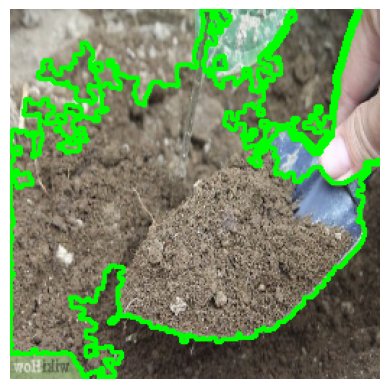

In [7]:
seg_img = segmentation(r"C:\Users\pawar\Downloads\CV Proj\Dataset\Aug\Train_Aug\Alluvial soil\Alluvial soil_flipped_v4-460px-Make-Clay-from-Indigenous-Soil-Step-1-Version-2.jpg",print_image=True)

(-0.5, 255.5, 255.5, -0.5)

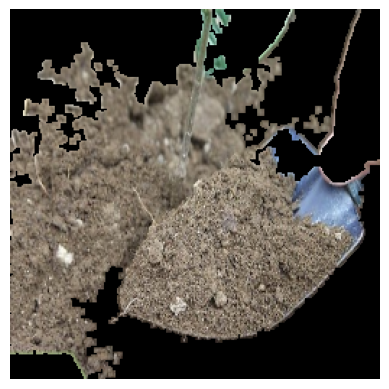

In [8]:
plt.imshow(cv2.cvtColor(seg_img, cv2.COLOR_BGR2RGB))
plt.axis('off')

## Feature Extraction Techniques

###  1. Gabor Filter Features

* Total 48 Kernels are used with 6 orientations , 4 wavelengths (lambda) and 2 Spatial aspect ratio (gamma) for each image.
* A feature vector of size 96 is created by appending mean squared energy and amplitude of for each filter result.

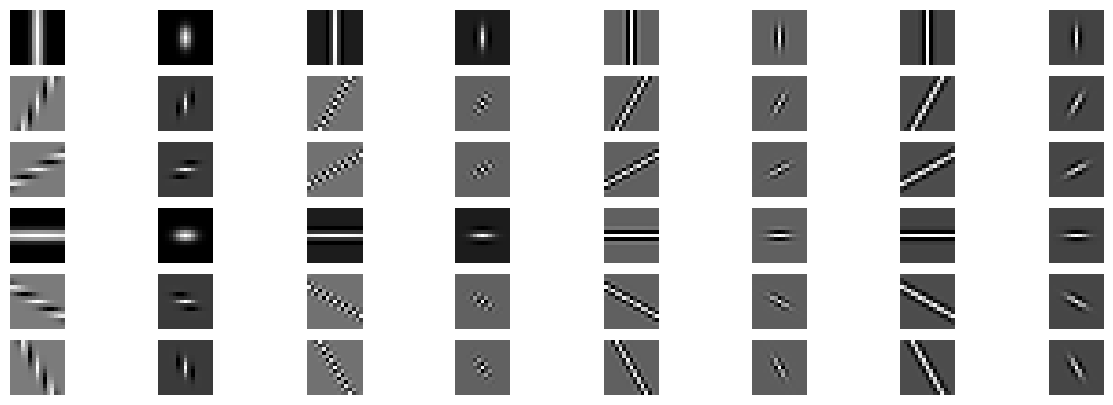

Gabor Feature Vector:
[  1.00716715 254.99757568   4.1611613  253.23528402   3.29916504
 253.84592448  23.85539551 234.74973958 105.44450684  55.53793457
  89.18669515  19.76836507  40.20923177 217.84025716 108.26108561
 108.9653776   91.22719076  73.49013346 106.0980249  102.54891846
  82.95070068  16.19211344  11.54313883   2.0498055  101.30938395
  42.81917887  78.26150798  13.43592529  33.43509033 224.57316162
 108.22141276 108.72514811  86.98927572  75.61884603 104.78415609
 102.8474113   82.09888346  16.1214388   10.94384521   1.92636637
  98.54981771  43.86929362  75.848632    13.97436605  35.03813151
 222.03541504 107.80879313 108.79441813   1.00226562 254.99925456
   4.13401042 253.25274902   3.29790446 253.94536051  25.06159342
 233.91241862  99.65026204  56.98124837  84.75418213  20.80651449
  42.17085286 213.9155013  107.78860189 109.02901204  84.03524658
  77.25037842 104.09700439 102.98066488  81.72957357  16.19165527
  11.24902995   2.00659342 103.81648356  42.58905843  

In [9]:
def calculate_gabor_feature(image,print_kernels=False):
    
    img_gray=cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    # Define Gabor filter parameters
    num_orientations = 6
    kernel_size = 15
    sigma = 1.0 # standard deviation of gaussian envelope
    phi = 0.0
    # Initialize an empty feature vector
    feature_vector = []
    # Apply Gabor filter for each scale and orientation
    kernels = []
    for orientation in range(num_orientations):
        for lambd in np.arange(0.5, np.pi, np.pi / 4):
            for gamma in [0.05,0.5]:
            # Create Gabor kernel
                gabor_kernel = cv2.getGaborKernel(
                    (kernel_size, kernel_size),
                    sigma,
                    np.radians(orientation * 180.0 / num_orientations),
                    lambd,
                    gamma,
                    phi,
                    ktype=cv2.CV_32F
                )
                kernels.append(gabor_kernel)
                # Apply Gabor filter to the grayscale image
                filtered_image = cv2.filter2D(img_gray, cv2.CV_8UC3, gabor_kernel)            
                # Calculate mean-squared energy and mean amplitude
                mean_squared_energy = np.mean(filtered_image**2)
                mean_amplitude = np.mean(np.abs(filtered_image))
                # Append the features to the feature vector
                feature_vector.append(mean_squared_energy)
                feature_vector.append(mean_amplitude)
                
    if print_kernels:
        fig, axs = plt.subplots(num_orientations, 4 * 2, figsize=(15, 5))
        for i, kernel in enumerate(kernels):
            orientation_idx = i // 8
            scale_idx = (i // 2) % 4
            gamma_idx = i % 2
            axs[orientation_idx, scale_idx * 2 + gamma_idx].imshow(kernel, cmap='gray')
            axs[orientation_idx, scale_idx * 2 + gamma_idx].axis('off')
    
        plt.show()
        
#     Convert the feature vector to a NumPy array
    feature_vector = np.array(feature_vector)

    return feature_vector

image = cv2.imread('Dataset/Train/Clay Soil/1523893451317.jpeg')
gabor_feature = calculate_gabor_feature(image,print_kernels=True)

print("Gabor Feature Vector:")
print(gabor_feature)


### 2. HSV Histogram Feature Vector

* Image is converted into HSV colorspace and histogram feature vector is created across each space

In [69]:
def calculate_hsv_histogram(image):
    # Read the segmented image
    # Convert the image to HSV color space
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Define the number of bins for each channel
    h_bins, s_bins, v_bins = 8, 2, 2

    # Define the ranges for each channel
    h_range = [0, 180]
    s_range = [0, 256]
    v_range = [0, 256]

    # Calculate the histogram
    hist = cv2.calcHist([hsv_image], [0, 1, 2], None, [h_bins, s_bins, v_bins], [h_range[0], h_range[1], s_range[0], s_range[1], v_range[0], v_range[1]])

    # Flatten the histogram into a 1D vector
    hist_vector = hist.flatten()

    # Normalize the histogram vector
    hist_vector /= hist_vector.sum()
    return hist_vector

# Example usage
image = cv2.imread('Dataset/Train/Clay Soil/1523893451317.jpeg')
histogram_vector = calculate_hsv_histogram(image)

print("HSV Histogram Vector:")
print(histogram_vector)
print("Length of HSV vector" ,len(histogram_vector))

HSV Histogram Vector:
[9.3055829e-02 4.4434083e-01 2.6701903e-01 1.2078125e-01 1.9042968e-04
 1.8424479e-03 2.1256511e-03 3.3398438e-03 2.1972657e-05 1.5055339e-04
 0.0000000e+00 0.0000000e+00 3.3365886e-05 1.0660807e-04 0.0000000e+00
 0.0000000e+00 1.8310547e-04 2.3437499e-04 9.3587238e-05 7.1614581e-05
 2.4959310e-03 4.8583985e-04 8.9518226e-06 0.0000000e+00 1.2893880e-02
 3.9143881e-04 1.5462239e-05 0.0000000e+00 4.7168784e-02 2.7921549e-03
 1.4078776e-04 1.6276043e-05]
Length of HSV vector 32


### 3. Calculating Color Moments across RGB channels

In [11]:
def calculate_color_moments(image):
    
    # Convert the image to RGB (OpenCV uses BGR by default)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # Calculate color moments for each channel
    moments = []
    for channel in range(3):  # 0: Red, 1: Green, 2: Blue
        # Calculate mean, standard deviation, and skewness
        mean_value = np.mean(image_rgb[:, :, channel])
        std_dev = np.std(image_rgb[:, :, channel])
        skewness = np.mean((image_rgb[:, :, channel] - mean_value) ** 3) / (std_dev ** 3)
        # Append the calculated moments to the list
        moments.extend([mean_value, std_dev, skewness])
    # Create a feature vector from the calculated moments
    feature_vector = moments
    return feature_vector

# Example usage
image = cv2.imread('Dataset/Train/Clay Soil/1523893451317.jpeg')
feature_vector = calculate_color_moments(image)

print("Color Moments Feature Vector:")
print(feature_vector)

Color Moments Feature Vector:
[136.06764892578124, 59.22625188539598, -0.2833903593529897, 99.687294921875, 50.26929884098048, 0.08253695413049073, 77.59957275390624, 46.19002546848938, 0.4806046782239422]


In [12]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

def count_files_in_folder(folder_path):
    file_count = 0
    for filename in os.listdir(folder_path):
        filepath = os.path.join(folder_path, filename)
        if os.path.isfile(filepath):
            file_count += 1
    return file_count

# Loop through each file in the folder to create a feature vector for each input image
def create_features(main_folder_path):
    feature_vectors = []
    labels =  []
    print(f"For {main_folder_path}")
    for class_folder in os.listdir(main_folder_path):
        class_folder_path = os.path.join(main_folder_path, class_folder)
        num_files = count_files_in_folder(class_folder_path)
        print(f"{num_files} images used for {class_folder}")
        for filename in os.listdir(class_folder_path):
            
            if filename.endswith(('.jpg', '.jpeg', '.png')):  # Add more extensions if needed
                # Load the image
                image_path = os.path.join(class_folder_path, filename)
                # print(image_path)
                image = cv2.imread(image_path)
                
                seg_img = segmentation(image_path)
                
                # Calculate the feature vector using segmented image
                gabor_vector = calculate_gabor_feature(seg_img)
        
                color_moment_vector = calculate_color_moments(seg_img)
                
                hist_vector = calculate_hsv_histogram(seg_img)
                
                # Combine all features and store the feature vector        
                combined_feature = np.append(gabor_vector, hist_vector)
                combined_feature = np.append(combined_feature, np.array(color_moment_vector))
                feature_vectors.append(combined_feature)
                labels.append(classes[class_folder])
                
    return feature_vectors, labels




In [13]:
train_feature_vector , train_labels = create_features('Dataset\\Dataset_Final\\Dataset\\train\\')
test_feature_vector , test_labels = create_features('Dataset\\Dataset_Final\\Dataset\\test\\')

For Dataset\Dataset_Final\Dataset\train\
499 images used for Alluvial soil
181 images used for Black Soil
214 images used for Clay soil
246 images used for Red soil
For Dataset\Dataset_Final\Dataset\test\
125 images used for Alluvial soil
46 images used for Black Soil
54 images used for Clay soil
62 images used for Red soil


### Augmented Dataset

In [14]:
train_feature_vector_aug , train_labels_aug = create_features('Dataset\\Dataset_Final\\Aug_Dataset\\train\\')
test_feature_vector_aug , test_labels_aug = create_features('Dataset\\Dataset_Final\\Aug_Dataset\\test\\')

For Dataset\Dataset_Final\Aug_Dataset\train\
1859 images used for Alluvial soil
704 images used for Black Soil
793 images used for Clay soil
854 images used for Red soil
For Dataset\Dataset_Final\Aug_Dataset\test\
465 images used for Alluvial soil
176 images used for Black Soil
199 images used for Clay soil
214 images used for Red soil


In [15]:
# To test model performance on sample images
def create_feature_vector_from_image(path):
    seg_img = segmentation(path)
    feature = []
    # Calculate the feature vector
    gabor_vector = calculate_gabor_feature(seg_img)
    color_moment_vector = calculate_color_moments(seg_img)
    hist_vector = calculate_hsv_histogram(seg_img)
    combined_feature = np.append(gabor_vector, hist_vector)
    combined_feature = np.append(combined_feature, np.array(color_moment_vector))
    feature.append(combined_feature)
    return feature

In [43]:
test_image_paths = {r'C:\Users\pawar\Downloads\CV Proj\Dataset\red.jpg':"Red Soil", 
                    r'C:\Users\pawar\Downloads\CV Proj\Dataset\rd.jpg':"Red Soil",
                    r'C:\Users\pawar\Downloads\CV Proj\Dataset\alluvial.jpg':"Alluvial Soil", 
                    r'C:\Users\pawar\Downloads\CV Proj\Dataset\allu.jpeg':"Alluvial Soil",
                    r'C:\Users\pawar\Downloads\CV Proj\Dataset\black.jpg':"Black Soil",
                    r'C:\Users\pawar\Downloads\CV Proj\Dataset\blck.jpeg':"Black Soil", 
                    r'C:\Users\pawar\Downloads\CV Proj\Dataset\clay.jpg':"Clay Soil",
                    r'C:\Users\pawar\Downloads\CV Proj\Dataset\cll.jpg':"Clay Soil"}


In [60]:
def plot_predictions(model):
    fig, axs = plt.subplots(2, 4, figsize=(10, 8))
    axs = axs.flatten()
    for i, (img_path,actual_label) in enumerate(test_image_paths.items()):
        # Preprocess the image
        img_array = create_feature_vector_from_image(img_path)
        img  = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img,(256,256))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # Predict the label
        y_pred_sample=model.predict(img_array)
        predicted_label = next((key for key, value in classes.items() if value == y_pred_sample), None)
    
        # Display the original image
        axs[i].imshow(img)
        
        # Set the predicted label as the title
        axs[i].set_title(f'Predicted Label: {predicted_label} \n Actual Label: {actual_label}')
        axs[i].axis('off')
    fig.patch.set_facecolor('#f2ead3')
    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()
    

## Random Forest Classifier

In [18]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,classification_report

# Hyperparameter tuning using GridSearchCV
param_dist = {
    'n_estimators': [100,200,300],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [10, 20, 30, 50],
}

rf_classifier = RandomForestClassifier()

grid_search_rf = GridSearchCV(
    rf_classifier,
    param_grid=param_dist,
    scoring='accuracy',
    cv=4, 
    verbose=1
)

# Fit the model on the entire training set
grid_search_rf.fit(train_feature_vector,train_labels)

# Print the best hyperparameters
print("Best Hyperparameters:", grid_search_rf.best_params_)

# Make predictions on the test set
y_pred = grid_search_rf.predict(test_feature_vector)

Fitting 4 folds for each of 24 candidates, totalling 96 fits
Best Hyperparameters: {'max_depth': 20, 'max_features': 'log2', 'n_estimators': 300}


In [19]:
# Evaluate the model on the test set
test_accuracy = accuracy_score(test_labels, y_pred)
print("Test Set Accuracy:", test_accuracy)
print(classification_report(y_pred,test_labels))

Test Set Accuracy: 0.9825783972125436
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       120
           1       1.00      1.00      1.00        46
           2       1.00      0.92      0.96        59
           3       1.00      1.00      1.00        62

    accuracy                           0.98       287
   macro avg       0.99      0.98      0.98       287
weighted avg       0.98      0.98      0.98       287



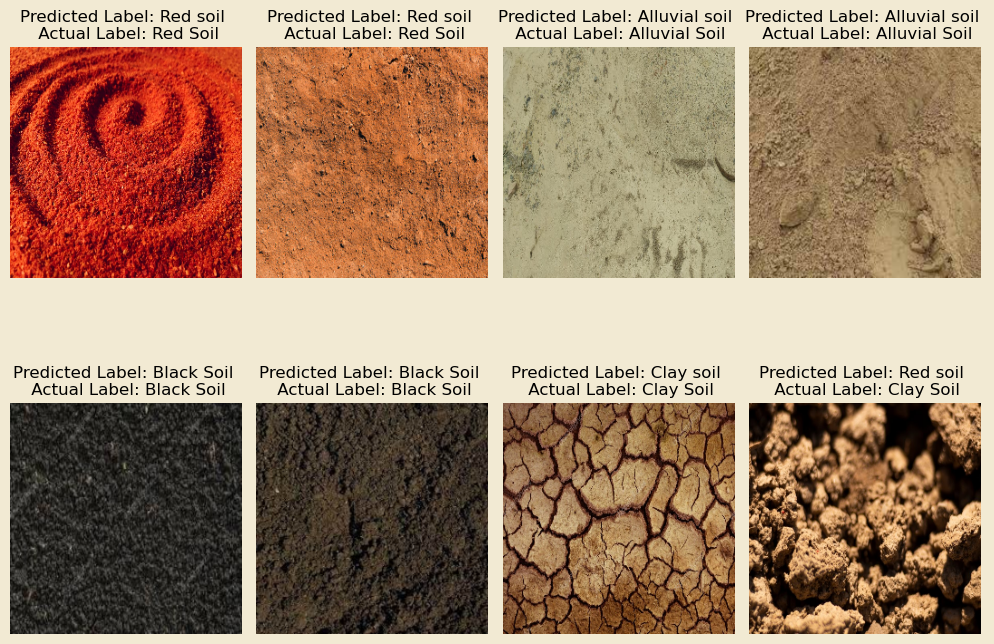

In [61]:
plot_predictions(grid_search_rf)

#### Augmented  Dataset

In [21]:
rf_classifier_aug = RandomForestClassifier()

grid_search_rf_aug = GridSearchCV(
    rf_classifier_aug,
    param_grid=param_dist,
    scoring='accuracy',
    cv=4, 
    verbose=1
)
grid_search_rf_aug.fit(train_feature_vector_aug,train_labels_aug)
# Print the best hyperparameters
print("Best Hyperparameters:", grid_search_rf_aug.best_params_)
y_pred_aug = grid_search_rf_aug.predict(test_feature_vector_aug)
test_accuracy_aug = accuracy_score(test_labels_aug, y_pred_aug)
print("Test Set Accuracy:", test_accuracy_aug)
print(classification_report(y_pred_aug,test_labels_aug))

Fitting 4 folds for each of 24 candidates, totalling 96 fits
Best Hyperparameters: {'max_depth': 50, 'max_features': 'sqrt', 'n_estimators': 100}
Test Set Accuracy: 0.9800759013282733
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       463
           1       1.00      0.99      1.00       177
           2       0.94      0.97      0.96       193
           3       1.00      0.96      0.98       221

    accuracy                           0.98      1054
   macro avg       0.98      0.98      0.98      1054
weighted avg       0.98      0.98      0.98      1054



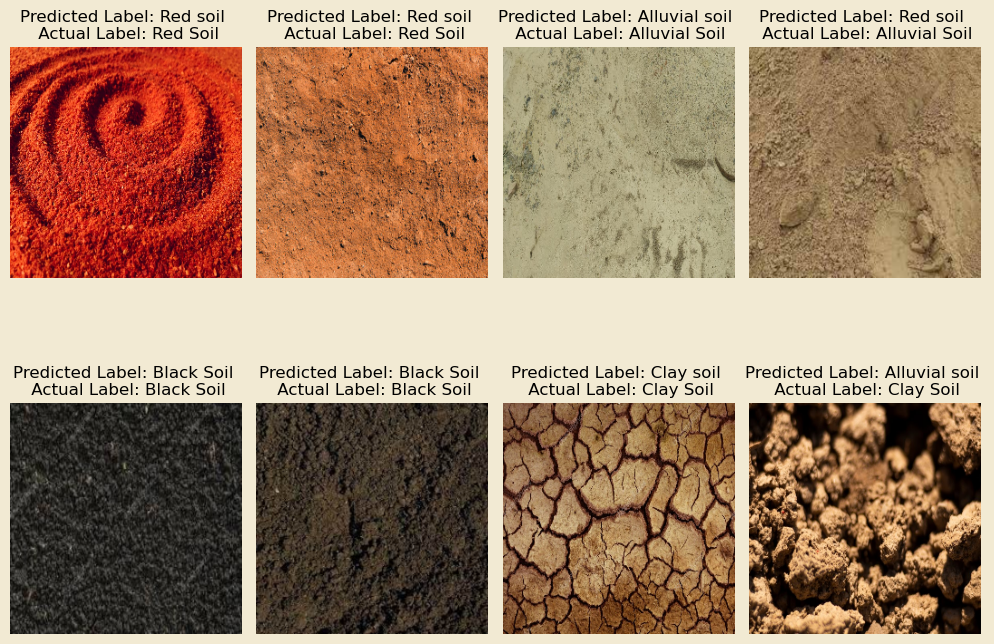

In [62]:
plot_predictions(grid_search_rf_aug)

## XGBoost

In [48]:
import xgboost as xgb

model_xgb = xgb.XGBClassifier()

param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'n_estimators': [50, 100, 200],
}

# Create the GridSearchCV object
grid_search = GridSearchCV(
    model_xgb,
    param_grid=param_grid,
    scoring='accuracy',
    cv=4, 
    verbose=1
)

grid_search.fit(train_feature_vector,train_labels)
print("Best Hyperparameters:", grid_search.best_params_)

y_pred_xg=grid_search.predict(test_feature_vector)
print("Test Set Accuracy:",accuracy_score(y_pred_xg,test_labels))
print(classification_report(y_pred_xg,test_labels))

Fitting 4 folds for each of 27 candidates, totalling 108 fits
Best Hyperparameters: {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200}
Test Set Accuracy: 0.975609756097561
              precision    recall  f1-score   support

           0       0.97      0.98      0.97       124
           1       1.00      1.00      1.00        46
           2       0.94      0.93      0.94        55
           3       1.00      1.00      1.00        62

    accuracy                           0.98       287
   macro avg       0.98      0.98      0.98       287
weighted avg       0.98      0.98      0.98       287



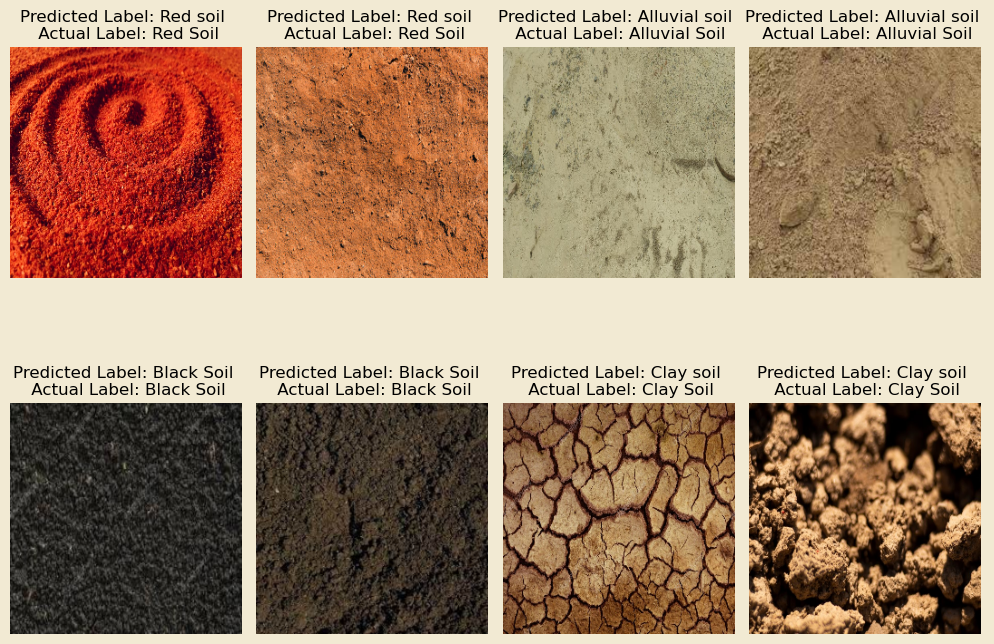

In [63]:
plot_predictions(grid_search)

#### Augmented Dataset

In [50]:
model_xgb_aug = xgb.XGBClassifier()

param_grid_aug = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'n_estimators': [50, 100, 200],
    'subsample': [0.8, 1.0],
}

# Create the GridSearchCV object
grid_search_aug = GridSearchCV(
    model_xgb_aug,
    param_grid=param_grid,
    scoring='accuracy',
    cv=4, 
    verbose=1
)

grid_search_aug.fit(train_feature_vector_aug,train_labels_aug)
print("Best Hyperparameters:", grid_search_aug.best_params_)

y_pred_xg_aug=grid_search_aug.predict(test_feature_vector_aug)
print("Test Set Accuracy:",accuracy_score(y_pred_xg_aug,test_labels_aug))
print(classification_report(y_pred_xg_aug,test_labels_aug))

Fitting 4 folds for each of 27 candidates, totalling 108 fits
Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
Test Set Accuracy: 0.9658444022770398
              precision    recall  f1-score   support

           0       0.97      0.96      0.97       470
           1       1.00      0.99      0.99       178
           2       0.92      0.95      0.94       192
           3       0.97      0.97      0.97       214

    accuracy                           0.97      1054
   macro avg       0.96      0.97      0.97      1054
weighted avg       0.97      0.97      0.97      1054



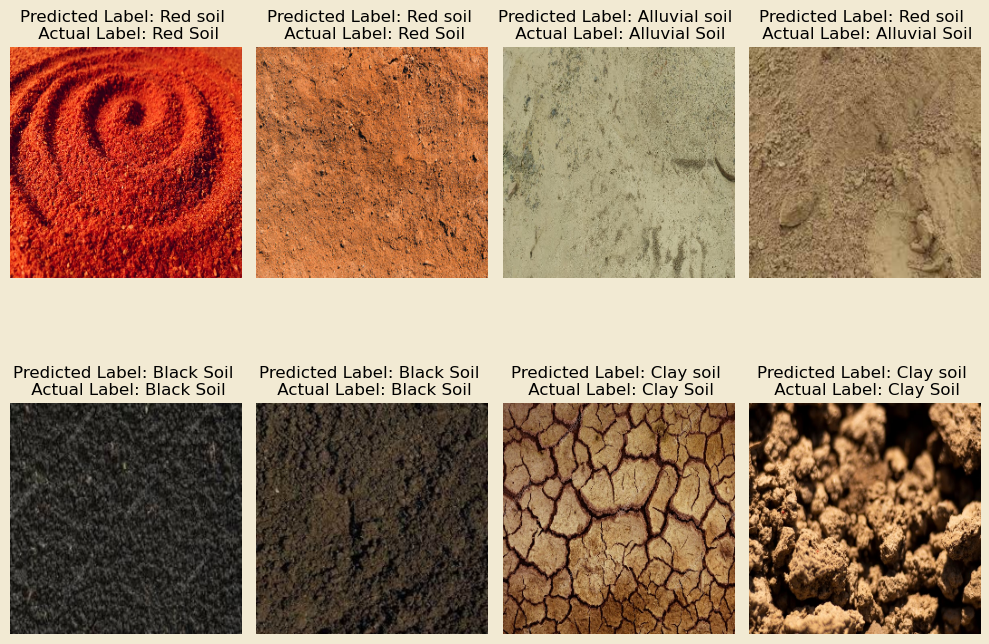

In [64]:
plot_predictions(grid_search_aug)